# Multiple linear regression 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## import data
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv").set_index("Id")
test = pd.read_csv("test.csv").set_index("Id")
combine = pd.concat([train, test])

# process data before model fitting
from preprocessfinal import impute
onehot, encodedDic = impute(combine, True) # process data and onehot encode

# seperate onehot data into train and test
train_onehot = onehot.iloc[0:1460,]
test_onehot = onehot.iloc[1460:2919,].drop('SalePrice', axis = 1) # salesprice col were all NA 

# split train data frame into x var and y var for model testing
x_onehot = train_onehot.drop('SalePrice', axis=1)
y_log = np.log(train_onehot.SalePrice) # convert y to normal distribution for regression models

### original y vs log(y) distirbution

In [2]:
from matplotlib import pyplot as plt
plt.hist(train_onehot.SalePrice, bins=50)  # original y

(array([  5.,  11.,  13.,  61.,  58., 126., 165., 180., 122., 130., 121.,
         78.,  61.,  64.,  49.,  36.,  36.,  25.,  13.,  25.,  16.,  11.,
          4.,  11.,   9.,   5.,   4.,   4.,   4.,   2.,   1.,   1.,   1.,
          0.,   1.,   0.,   2.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900.,  49302.,  63704.,  78106.,  92508., 106910., 121312.,
        135714., 150116., 164518., 178920., 193322., 207724., 222126.,
        236528., 250930., 265332., 279734., 294136., 308538., 322940.,
        337342., 351744., 366146., 380548., 394950., 409352., 423754.,
        438156., 452558., 466960., 481362., 495764., 510166., 524568.,
        538970., 553372., 567774., 582176., 596578., 610980., 625382.,
        639784., 654186., 668588., 682990., 697392., 711794., 726196.,
        740598., 755000.]),
 <a list of 50 Patch objects>)

(array([  2.,   2.,   1.,   0.,   0.,   0.,   2.,   3.,   4.,   3.,   5.,
          1.,   5.,  21.,  22.,  23.,  18.,  29.,  58.,  56.,  65., 100.,
        122.,  93.,  90.,  82., 108.,  91.,  64.,  55.,  58.,  51.,  46.,
         42.,  23.,  29.,  22.,  13.,  13.,  13.,   7.,   5.,   4.,   1.,
          2.,   2.,   2.,   0.,   0.,   2.]),
 array([10.46024211, 10.52172673, 10.58321134, 10.64469596, 10.70618058,
        10.7676652 , 10.82914982, 10.89063444, 10.95211906, 11.01360367,
        11.07508829, 11.13657291, 11.19805753, 11.25954215, 11.32102677,
        11.38251138, 11.443996  , 11.50548062, 11.56696524, 11.62844986,
        11.68993448, 11.75141909, 11.81290371, 11.87438833, 11.93587295,
        11.99735757, 12.05884219, 12.12032681, 12.18181142, 12.24329604,
        12.30478066, 12.36626528, 12.4277499 , 12.48923452, 12.55071913,
        12.61220375, 12.67368837, 12.73517299, 12.79665761, 12.85814223,
        12.91962684, 12.98111146, 13.04259608, 13.1040807 , 13.16556532,
 

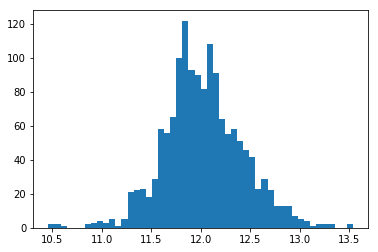

In [3]:
plt.hist(y_log, bins=50)  # log(y)


## Ridge regularization

#### Find best lambda

In [4]:
from sklearn.model_selection import GridSearchCV # search for the best lambda
from sklearn import linear_model

ridge = linear_model.Ridge(normalize=True) # create a ridge regression instance

# find the best alpha (lambda) for ridge
grid_param = [{'alpha': np.logspace(-4, 2, 100)}]
para_search_ridge = GridSearchCV(estimator=ridge, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_ridge.fit(x_onehot, y_log)

print(para_search_ridge.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(para_search_ridge.best_score_)))


{'alpha': 0.2848035868435802}
Lowest RMSE found:  0.13372256831658905


#### RMSE for all train data using best ridge

In [5]:
# fit best ridge equation to all train data 
best_ridge_y = para_search_ridge.best_estimator_.predict(x_onehot)
print("RMSE: ", np.sqrt(np.mean((y_log-best_ridge_y)**2)))


RMSE:  0.11292062271587874


#### RMSE across different grid search lambda

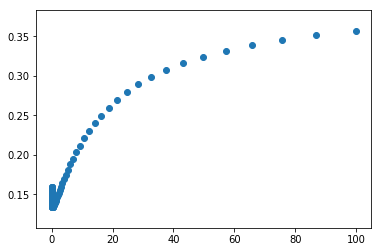

In [7]:
import warnings
warnings.filterwarnings('ignore')
error = pd.DataFrame(para_search_ridge.grid_scores_)['mean_validation_score']  # or para_search_ridge.cv_results_['mean_test_score']
error = np.sqrt(np.abs(error))
alpha = pd.DataFrame(para_search_ridge.grid_scores_)['parameters'].apply(lambda x: x.get('alpha'))
plt.scatter(alpha, error)

#### Variable importance for best lambda

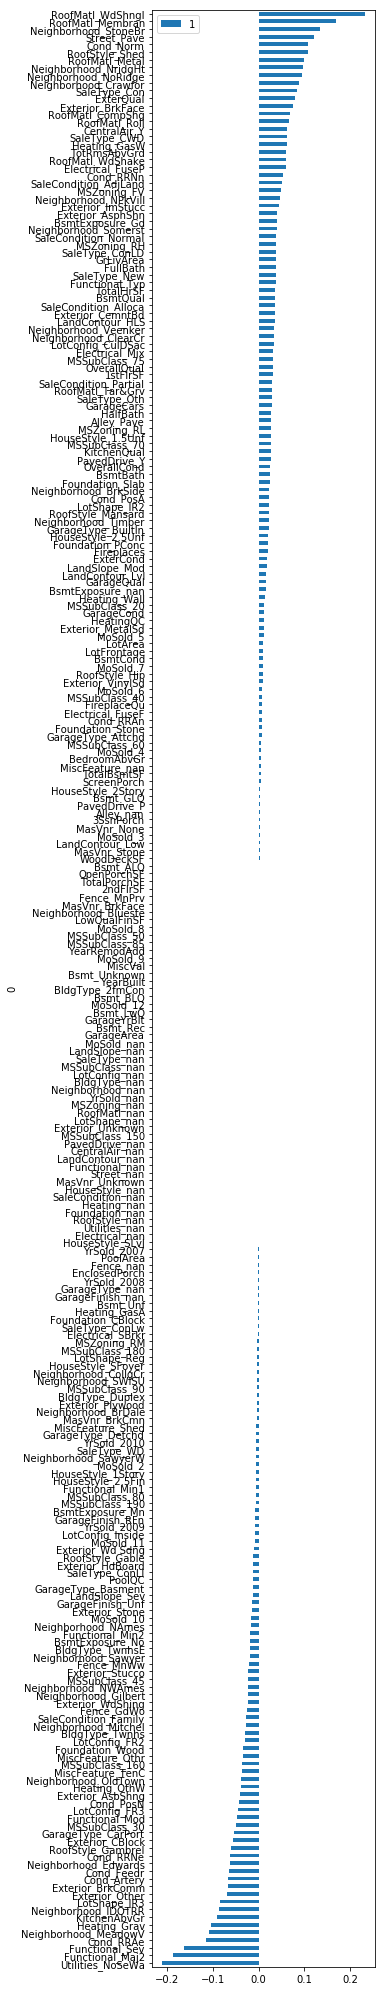

In [9]:
pd.DataFrame(list(zip(x_onehot.columns, para_search_ridge.best_estimator_.coef_))).set_index(0).sort_values(1).plot.barh()
plt.rcParams['figure.figsize'] = 4, 36

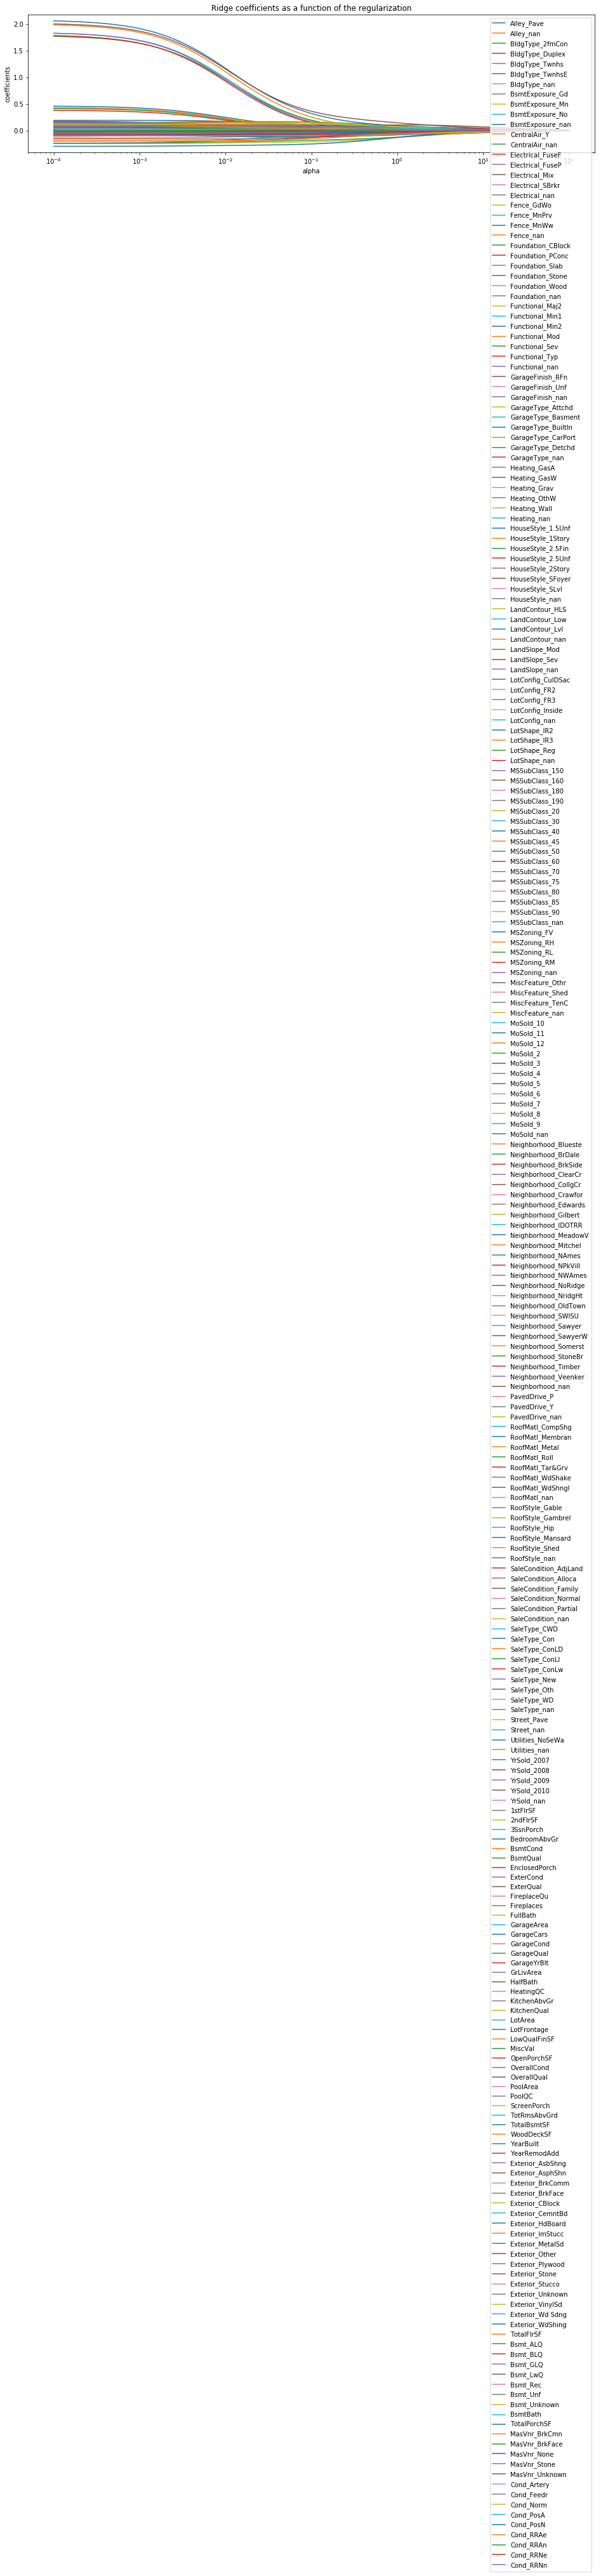

In [11]:
alpha_100 = np.logspace(-4, 2, 100)
coef = []
for i in alpha_100:
    ridge.set_params(alpha = i)
    ridge.fit(x_onehot, y_log)
    coef.append(ridge.coef_)

df_coef = pd.DataFrame(coef, index=alpha_100, columns=x_onehot.columns)
title = 'Ridge coefficients as a function of the regularization'
axes = df_coef.plot(logx=True, title=title)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')
plt.rcParams['figure.figsize'] = 16, 4

#### test prediction

In [12]:
best_ridge_test_y = para_search_ridge.best_estimator_.predict(test_onehot)
best_ridge_test_y = np.expm1(best_ridge_test_y)
best_ridge_test_y
sub = pd.DataFrame()
sub['SalePrice'] = best_ridge_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('(1) ridge_log(y)_onehot_submission.csv')

## Lasso regularization

#### Find best lambda

In [13]:
lasso = linear_model.Lasso(normalize=True) # create a ridge regression instance

# find the best alpha (lambda) for lasso 
grid_param = [{'alpha': np.logspace(-4.5, 2, 100)}]
para_search_lasso = GridSearchCV(estimator=lasso, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_lasso.fit(x_onehot, y_log)

print(para_search_lasso.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(para_search_lasso.best_score_)))

{'alpha': 0.0001232846739442066}
Lowest RMSE found:  0.12730800492203845


#### RMSE for all train data using best lasso

In [14]:
# fit best lasso equation to all train data 
best_lasso_y = para_search_lasso.best_estimator_.predict(x_onehot)
print("RMSE: ", np.sqrt(np.mean((y_log-best_lasso_y)**2)))

RMSE:  0.11676135911841964


#### RMSE across different grid search lambda

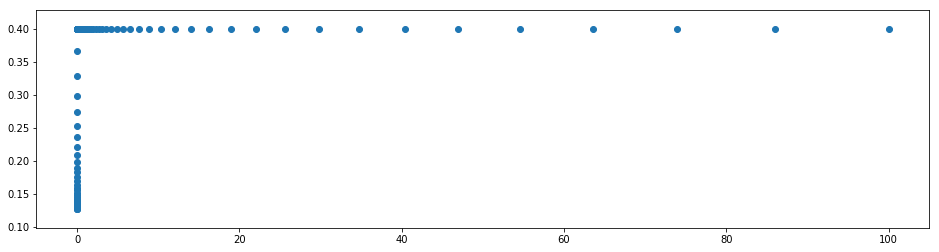

In [15]:
error = pd.DataFrame(para_search_lasso.grid_scores_)['mean_validation_score']
error = np.sqrt(np.abs(error))
alpha = pd.DataFrame(para_search_lasso.grid_scores_)['parameters'].apply(lambda x: x.get('alpha'))
plt.scatter(alpha, error)

#### Variable importance for best lambda

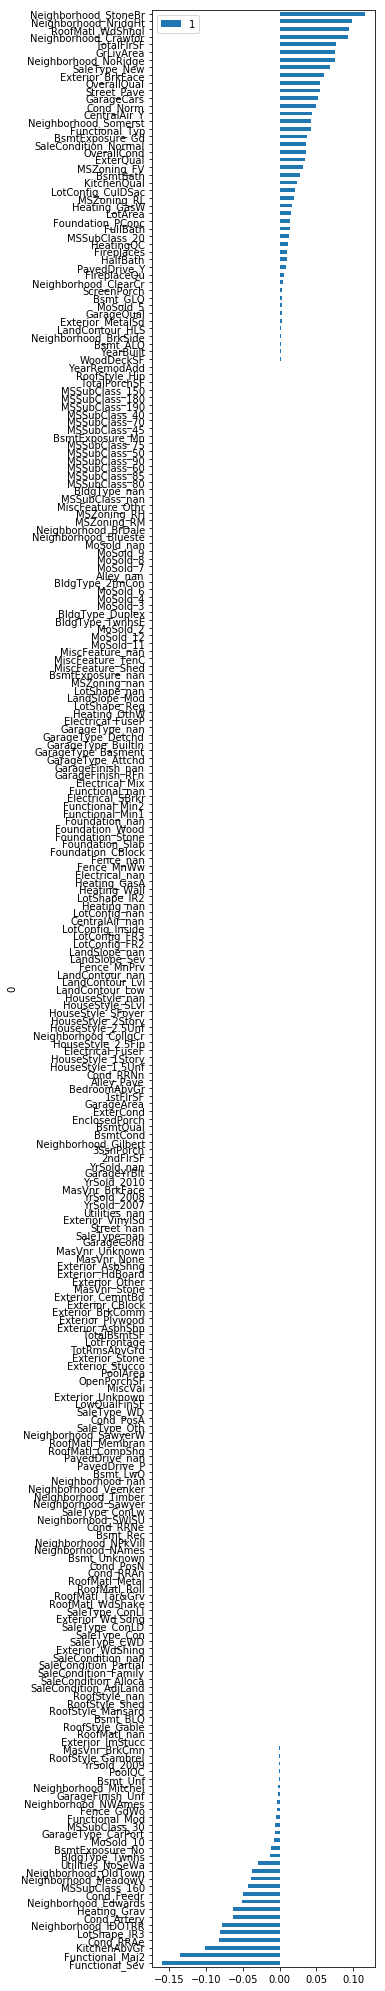

In [23]:
pd.DataFrame(list(zip(x_onehot.columns, para_search_lasso.best_estimator_.coef_))).set_index(0).sort_values(1).plot.barh()
plt.rcParams['figure.figsize'] = 4, 36

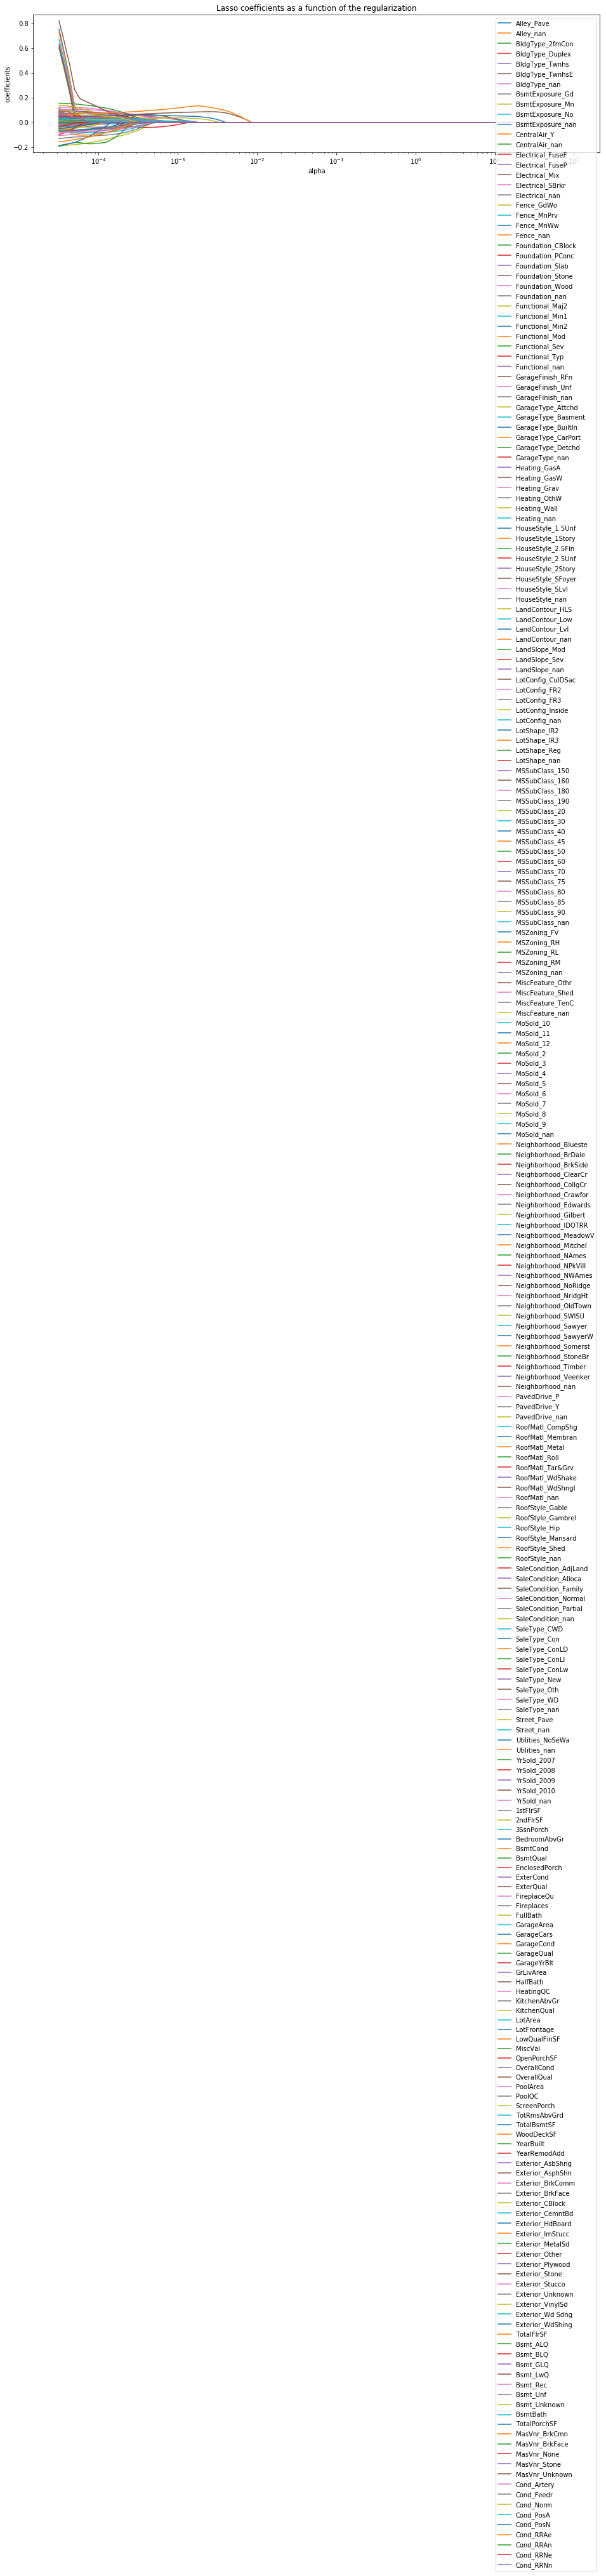

In [25]:
alpha_100 = np.logspace(-4.5, 2, 100)
coef = []
for i in alpha_100:
    lasso.set_params(alpha = i)
    lasso.fit(x_onehot, y_log)
    coef.append(lasso.coef_)

df_coef = pd.DataFrame(coef, index=alpha_100, columns=x_onehot.columns)
title = 'Lasso coefficients as a function of the regularization'
axes = df_coef.plot(logx=True, title=title)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')
plt.rcParams['figure.figsize'] = 16, 4

#### test prediction

In [26]:
best_lasso_test_y = para_search_lasso.best_estimator_.predict(test_onehot)
best_lasso_test_y = np.expm1(best_lasso_test_y)
sub = pd.DataFrame()
sub['SalePrice'] = best_lasso_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('(2) lasso_log(y)_onehot_submission.csv')

## Elastic net regularization

In [27]:
elasticnet = linear_model.ElasticNet(normalize=True) # create a ridge regression instance

# find the best alpha (lambda) for lasso 
grid_param = [{'alpha': np.logspace(-10, 6, 100), 'l1_ratio': np.arange(0, 1.1, 0.1)}]
para_search_elas = GridSearchCV(estimator=elasticnet, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_elas.fit(x_onehot, y_log)

print(para_search_elas.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(para_search_elas.best_score_)))


{'alpha': 0.00013848863713938745, 'l1_ratio': 0.9}
Lowest RMSE found:  0.12738724030490256


#### RMSE for all train data using best lasso

In [28]:
# fit best elastic net equation to all train data 
best_elas_y = para_search_elas.best_estimator_.predict(x_onehot)
print("RMSE: ", np.sqrt(np.mean(y_log-best_elas_y)**2))

RMSE:  9.076453439675252e-16


#### RMSE across different grid search lambda

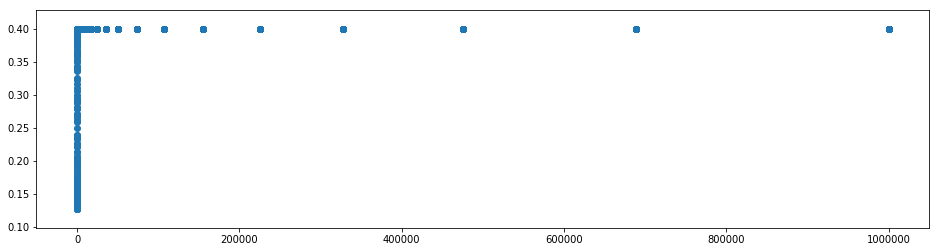

In [29]:
error = pd.DataFrame(para_search_elas.grid_scores_)['mean_validation_score']
error = np.sqrt(np.abs(error))
alpha = pd.DataFrame(para_search_elas.grid_scores_)['parameters'].apply(lambda x: x.get('alpha'))
plt.scatter(alpha, error)

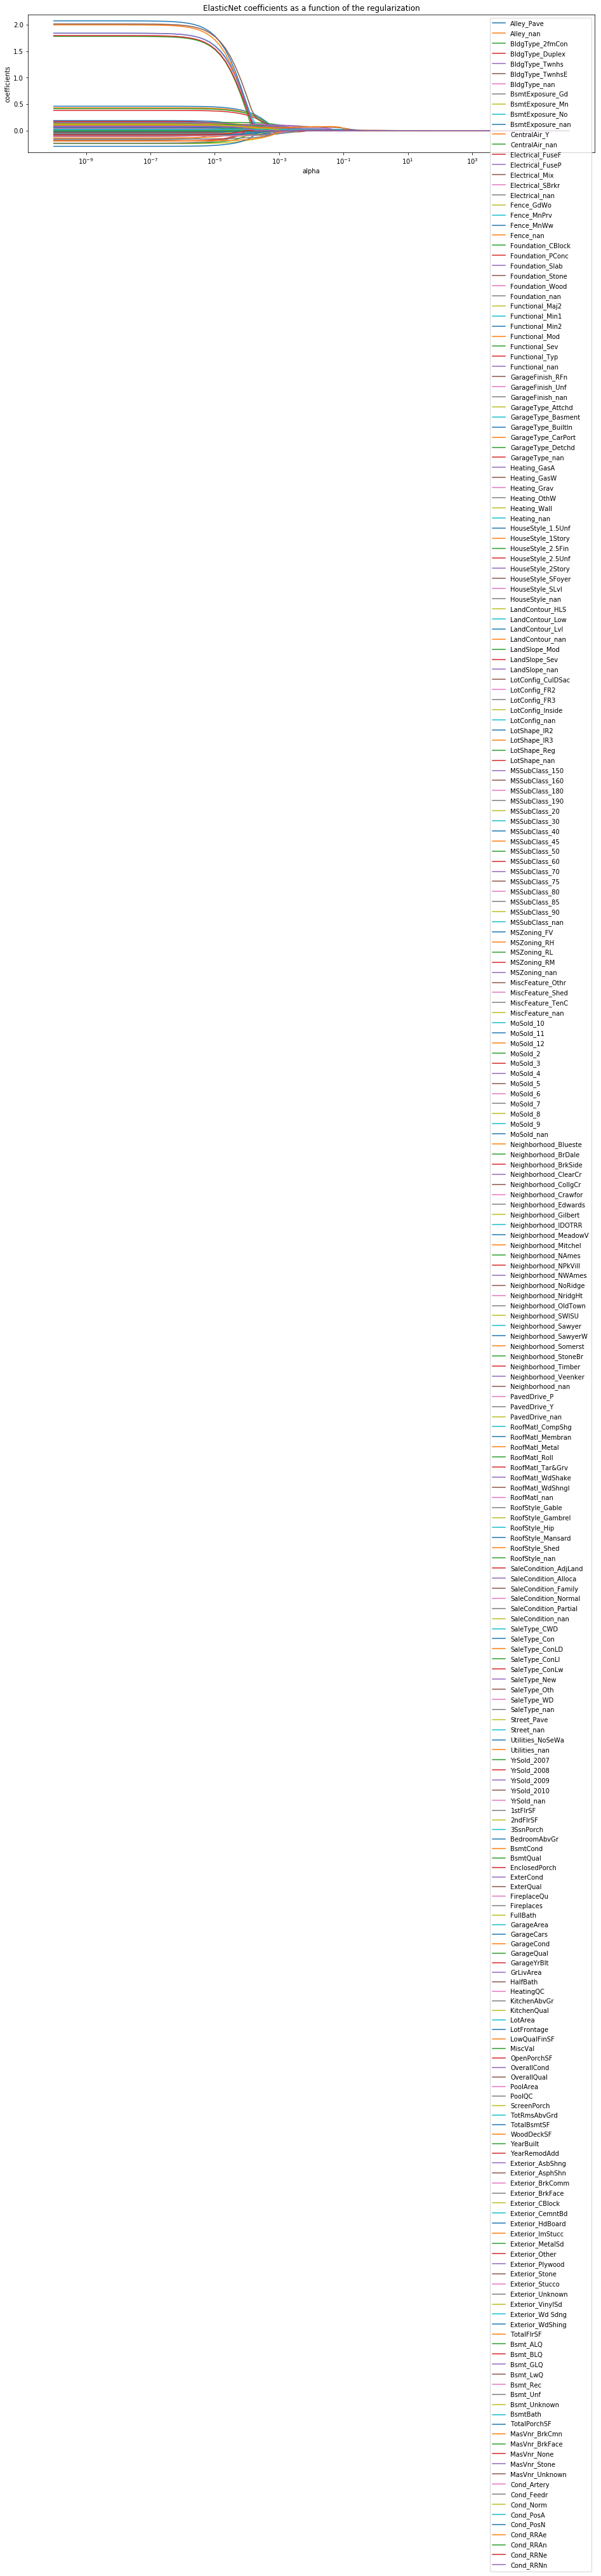

In [30]:
alphas_elastic = np.logspace(-10, 6, 100)
coef_elastic = []
for i in alphas_elastic:
    elastic = linear_model.ElasticNet(l1_ratio =0.6)
    elastic.set_params(alpha = i)
    elastic.fit(x_onehot, y_log)
    coef_elastic.append(elastic.coef_)

df_coef = pd.DataFrame(coef_elastic, index=alphas_elastic, columns=x_onehot.columns)
title = 'ElasticNet coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.show()

#### test prediction

In [31]:
best_elas_test_y = para_search_elas.best_estimator_.predict(test_onehot)
best_elas_test_y = np.expm1(best_elas_test_y)
sub = pd.DataFrame()
sub['SalePrice'] = best_elas_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('(3) elas_log(y)_onehot_submission.csv')